# Downloading Wayback Satellite images with timestamp using boundary .shp file
### ※ Last Modified: 2022/01/10 by Jeongkyung Won (jongrudwon@sogang.ac.kr)
#### 1. Importing the boundary .shp file using geopandas
#### 2. Creating OO_yx.csv
#### 3. Using OO_yx.csv, generate  1) ozyx_OO.json file and 2) odat_OO.csv file
#### 4. Using the files generated in 3, run two python files
  *  4.1. Image_downloader_shuf_v2.py 
  *  4.2. Image_downloader_from_csv_v2.py

In [1]:
import os
print(os.getcwd())

/content


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/production/satellite_image_download

/content/drive/MyDrive/production/satellite_image_download


In [4]:
!nvidia-smi

Sun Feb 13 02:45:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Importing the boundary shp file using geopandas

In [ ]:
pip install geopandas

     |████████████████████████████████| 1.0 MB 4.2 MB/s 
     |████████████████████████████████| 16.7 MB 24.6 MB/s 
     |████████████████████████████████| 6.3 MB 34.7 MB/s 


In [ ]:
import geopandas as gpd
#대상 path (.shp의 crs가 epsg4326이 아니면 변환을 먼저해주는 것이 편리)
path = './metro_boundary_v2.shp'
encoding='euc-kr'
geofile=gpd.read_file(path,encoding=encoding)

In [ ]:
geofile=geofile.to_crs(epsg=4326)

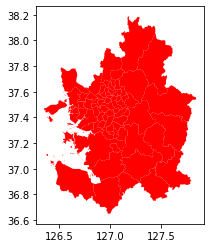

In [ ]:
geofile.plot(color='red')

In [ ]:
print(geofile.columns)

Index(['base_year', 'sigungu_cd', 'sigungu_nm', '_mean', '_median',
       'geometry'],
      dtype='object')


In [ ]:
geofile.to_csv('metro_mold.csv',index=False)

## 2. Creating *_yx.csv: a csv with all corresponding y_x(grid_id) for each district

In [ ]:
# Importing necessary modules 
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import convert as conv # make sure to upload convert.py in the working directory
import pandas as pd

In [ ]:
zl = 17 # set zoom level

In [ ]:
# This shell is to address the potential issues with multiple polygons
areaid_list = []
areaname_list = []
geom_list = []

for i in range(len(geofile)):
	#areaid = SIG_CD
	areaid = geofile.iloc[i]['sigungu_cd']
	areaid_list.append(areaid)
	#areaname = SIG_ENG_NM
	areaname = geofile.iloc[i]['sigungu_nm']
	areaname_list.append(areaname)
	#geom
	geom = geofile.iloc[i]['geometry']
	try:
		#when multipolygon
		multipoly_list = list(geom)
		geom_list.append(multipoly_list)
	except:
		#when polygon
		geom_list.append(geom)

areaid_geom_dict = dict(zip(areaid_list,geom_list))
areaid_name_dict = dict(zip(areaid_list,areaname_list)) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.


In [ ]:
def extractZYX(zoomlevel,polygon):
	xlist = []
	ylist = []
	result = []
	polygon = list(zip(*polygon.exterior.coords.xy))
	for lnglat in polygon:
		lat = lnglat[1]
		lng = lnglat[0]
		xtile, ytile = conv.deg2num(lat,lng,zoomlevel)
		xlist.append(xtile)
		ylist.append(ytile)
	xmin, xmax, ymin, ymax = min(xlist), max(xlist), min(ylist), max(ylist)
	new_xlist = list(range(xmin,xmax))
	new_ylist = list(range(ymin,ymax))
	tf_table = [tf[:] for tf in [[None] * (xmax-xmin+1)] * (ymax-ymin+1)]
	for y in list(range(ymin,ymax+1)):
		for x in list(range(xmin,xmax+1)):
			lat,lng = conv.num2deg(x,y,zoomlevel)
			tf_table[y-ymin][x-xmin] = 1 if Polygon(polygon).contains(Point(lng,lat)) else 0
	for y in new_ylist:
		for x in new_xlist:
			if tf_table[y-ymin][x-xmin] + tf_table[y-ymin][x-xmin+1] + tf_table[y-ymin+1][x-xmin] + tf_table[y-ymin+1][x-xmin+1] >=2:
				result.append([zoomlevel, y, x])
	return result

In [ ]:
# 시군구에 소속된 grid_id.csv파일명 지정. 이걸 바탕으로 ozyx json파일과 odat csv파일을 만들 것임. 
output_csv = 'metro_yx.csv'

In [ ]:
areaid_df = []
district_df = []
yx_df = []

for areaid in areaid_list:
	city_geom = areaid_geom_dict[areaid]
	city_zyx=[]
	if str(type(city_geom))==str(type([])):
		for item in city_geom:
			city_zyx += extractZYX(zl,item)
	else:
		city_name = areaid_name_dict[areaid]
		city_zyx = extractZYX(zl,city_geom)
	for zyx in city_zyx:
		areaid_df.append(areaid)
		district_df.append(city_name)
		yx_df.append(str(zyx[1])+'_'+str(zyx[2]))

df = pd.DataFrame({'areaid':areaid_df, 'district_name':district_df, 'yx_df':yx_df})
df.to_csv(output_csv,index=False)

## 3. Using OO_yx.csv, generate  1) ozyx_OO.json file and 2) odat_OO.csv file
*   These two files will be used to run .python files in the final step

In [ ]:
import collections
import json

In [ ]:
ozyx_filename = 'metro_zl17_kr.json'
odat_filename = 'metro_zl17_kr.csv'

In [ ]:
df_len = len(df)
ozyx_json = collections.OrderedDict()
odat_pd = {'areaID':[],'count':[]} 
for i in range(df_len):
	try:
		ozyx_json[df.iloc[i]['areaid']].append([zl,int(df.iloc[i]['yx_df'].split('_')[0]),int(df.iloc[i]['yx_df'].split('_')[1])])
		odat_pd['count'][-1]+=1
	except:
		ozyx_json[df.iloc[i]['areaid']]=[[zl,int(df.iloc[i]['yx_df'].split('_')[0]),int(df.iloc[i]['yx_df'].split('_')[1])]]
		odat_pd['areaID'].append(df.iloc[i]['areaid'])
		odat_pd['count'].append(1)
#ozyx
with open(ozyx_filename, 'w') as json_file:
    json.dump(ozyx_json, json_file)
#odat
odat_df = pd.DataFrame(odat_pd)
odat_df.to_csv(odat_filename,index=False)

## 4. Using the files generated in 3, run two python files

#### 4.1. Image_downloader_shuf_v2.py (220101 edited by jkwon): shuffled.csv 생성
*   !python3 image_downloader_shuf_v2.py --odat [odat_OO.csv파일] --ozyx [ozyx_OO.json파일] --odir [shuffled.csv가 저장될 폴더명]

In [ ]:
!python3 image_downloader_shuf_v2.py --odat metro_zl17_kr.csv --ozyx metro_zl17_kr.json --odir o_zl17_metro

['11010', '11020', '11030', '11040', '11050', '11060', '11070', '11080', '11090', '11100', '11110', '11120', '11130', '11140', '11150', '11160', '11170', '11180', '11190', '11200', '11210', '11220', '11230', '11240', '11250', '23010', '23020', '23030', '23040', '23050', '23060', '23070', '23080', '31011', '31012', '31013', '31014', '31021', '31022', '31023', '31030', '31041', '31042', '31050', '31060', '31070', '31091', '31092', '31101', '31110', '31120', '31130', '31140', '31150', '31160', '31170', '31180', '31191', '31192', '31193', '31210', '31220', '31230', '31240', '31250', '31260', '31270', '31280', '31370', '31380', '33350', '33370', '34012', '34040', '34080']
[37, 56, 11, 65, 51, 28, 40, 18, 47, 33, 21, 25, 16, 49, 20, 15, 45, 54, 34, 5, 36, 48, 42, 61, 43, 59, 6, 35, 50, 29, 60, 3, 74, 69, 32, 38, 71, 66, 12, 22, 27, 19, 46, 10, 7, 26, 63, 52, 58, 1, 73, 55, 2, 72, 4, 68, 30, 62, 39, 23, 17, 75, 64, 8, 70, 31, 53, 57, 13, 24, 41, 67, 14, 9, 44]


#### 4.2. Image_downloader_from_csv_v2.py (220101 edited by jkwon)
* !python3 image_downloader_from_csv_v2.py --shufdat [shuffled.csv가 저장된 위치] --ozyx [ozyx_OO.json 파일] --odir [위성영상이 저장될 폴더명] --process 2 --thread 4 --token a --wayback [timestamp 번호]
* timestamp의 번호는 Wayback에서 원하는 시점의 영상 zoom in한 상태에서 F12(개발자도구) => 로드 되는 사진 클릭 후 마우스 우클릭 => Open in new tab => 주소창에 마지막에 나오는 번호가 timestamp 번호 
* 예시: https://wayback.maptiles.arcgis.com/arcgis/rest/services/World_Imagery/WMTS/1.0.0/default028mm/MapServer/tile/3026/16/25382/55890  << '55890'이 timestamp 번호

In [ ]:
!python3 image_downloader_from_csv_v2.py --shufdat o_zl17_metro/shuffled_v2.csv --ozyx metro_zl17_kr.json --odir metro_zl17 --process 2 --thread 4 --token a --wayback 18063

11010 436
11020 181
11030 379
11040 307
11050 309
11060 250
11070 332
11080 439
11090 424
11100 374
11110 636
11120 526
11130 322
11140 428
11150 323
11160 729
11170 369
11180 231
11190 443
11200 295
11210 526
11220 833
11230 704
11240 599
11250 437
23010 2545
23020 136
23030 446
23040 1044
23050 1011
23060 581
23070 798
23080 2331
31011 585
31012 829
31013 240
31014 500
31021 806
31022 464
31023 1221
31030 1444
31041 645
31042 394
31050 948
31060 678
31070 7837
31091 1039
31092 2014
31101 2915
31110 631
31120 602
31130 7961
31140 741
31150 2477
31160 640
31170 954
31180 1638
31191 8058
31192 1421
31193 749
31210 7929
31220 9443
31230 4852
31240 13220
31250 7428
31260 5431
31270 14432
31280 10442
31370 14614
31380 15134
33350 6941
33370 8877
34012 3400
34040 9201
34080 12045
0/22 Finished
    Directory  ...  count
20         72  ...   2477
0           4  ...    640
18         68  ...    954
8          30  ...   1638
15         62  ...   8058

[5 rows x 3 columns]
areaID: 31150 Director

### ※ Optional: Download 받은 위성영상에 매치되는 wayback grid shape파일 만들기
* https://www.dropbox.com/sh/32vtjmvxsntuj2r/AAAlcDMizZdVsim3zjNPmghEa?dl=0 
* py파일을 위성영상이 위치한 폴더의 상위디렉토리에서 run
* !python3 grid_four_points.py -- z [zoom level] --dir [위성영상 위치 디렉토리] : 실행 완료 시 해당 디렉토리에 groud_four_points.csv 생성
* 나머지 작업은 QGIS에서 import해서 수행. Jay의 설명영상 참조

In [11]:
!python3 grid_four_points.py --z 17 --dir metro_zl17 # space 건드리지 않기

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
37.02448395075964 127.265625 37.02448395075964 127.26837158203125 37.02229110771149 127.265625
37.06613594074314 127.48809814453125 37.06613594074314 127.4908447265625 37.06394430056684 127.48809814453125
36.974032549418624 127.3919677734375 36.974032549418624 127.39471435546875 36.971838250931654 127.3919677734375
37.10338413422305 127.2711181640625 37.10338413422305 127.27386474609375 37.10119357072204 127.2711181640625
37.02448395075964 127.26837158203125 37.02448395075964 127.2711181640625 37.02229110771149 127.26837158203125
37.06613594074314 127.4908447265625 37.06613594074314 127.49359130859375 37.06394430056684 127.4908447265625
36.974032549418624 127.39471435546875 36.974032549418624 127.3974609375 36.971838250931654 127.39471435546875
37.10338413422305 127.27386474609375 37.10338413422305 127.276611328125 37.10119357072204 127.27386474609375
37.02448395075964 127.2711181640625 37.02448395075964 127.27386474609375 37.02229110771149 127.27111